In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings('ignore')

# Thiết lập kiểu trực quan hóa bằng seaborn
sns.set_style("whitegrid")  # Sử dụng seaborn để thiết lập style

In [6]:
# Đọc dữ liệu từ file CSV
df = pd.read_csv('Amazon-Products-Cleaned.csv')

# Xử lý dữ liệu
# Chuyển đổi kiểu dữ liệu và xử lý giá trị thiếu
df['ratings'] = pd.to_numeric(df['ratings'], errors='coerce')
df['no_of_ratings'] = pd.to_numeric(df['no_of_ratings'], errors='coerce')
df['discount_price'] = pd.to_numeric(df['discount_price'], errors='coerce')
df['actual_price'] = pd.to_numeric(df['actual_price'], errors='coerce')

# Điền giá trị thiếu
df['ratings'].fillna(df['ratings'].mean(), inplace=True)
df['no_of_ratings'].fillna(df['no_of_ratings'].median(), inplace=True)
df['discount_price'].fillna(df['actual_price'], inplace=True)
df['actual_price'].fillna(df['actual_price'].mean(), inplace=True)

# Tính số lượng bán giả định (dựa trên no_of_ratings và ratings)
df['quantity_sold'] = (df['no_of_ratings'] * df['ratings'] / 5).astype(int)

# Tính doanh thu (dựa trên discount_price và quantity_sold)
df['revenue'] = df['discount_price'] * df['quantity_sold']

# Thêm cột date giả định (giả sử dữ liệu trải dài trong 1 năm và lặp lại)
num_days = 365
dates = pd.date_range(start='2024-01-01', periods=num_days, freq='D')
df['date'] = [dates[i % num_days] for i in range(len(df))]

print("Dữ liệu sau khi xử lý:\n", df.head())
print("\nThông tin dữ liệu:\n")
df.info()

Dữ liệu sau khi xử lý:
                                                 name main_category  \
0  Lloyd 1.5 Ton 3 Star Inverter Split Ac (5 In 1...    appliances   
1  LG 1.5 Ton 5 Star AI DUAL Inverter Split AC (C...    appliances   
2  LG 1 Ton 4 Star Ai Dual Inverter Split Ac (Cop...    appliances   
3  LG 1.5 Ton 3 Star AI DUAL Inverter Split AC (C...    appliances   
4  Carrier 1.5 Ton 3 Star Inverter Split AC (Copp...    appliances   

       sub_category  ratings  no_of_ratings  discount_price  actual_price  \
0  Air Conditioners      4.2           2255           32999         58990   
1  Air Conditioners      4.2           2948           46490         75990   
2  Air Conditioners      4.2           1206           34490         61990   
3  Air Conditioners      4.0             69           37990         68990   
4  Air Conditioners      4.1            630           34490         67790   

   quantity_sold    revenue       date  
0           1894   62500106 2024-01-01  
1         

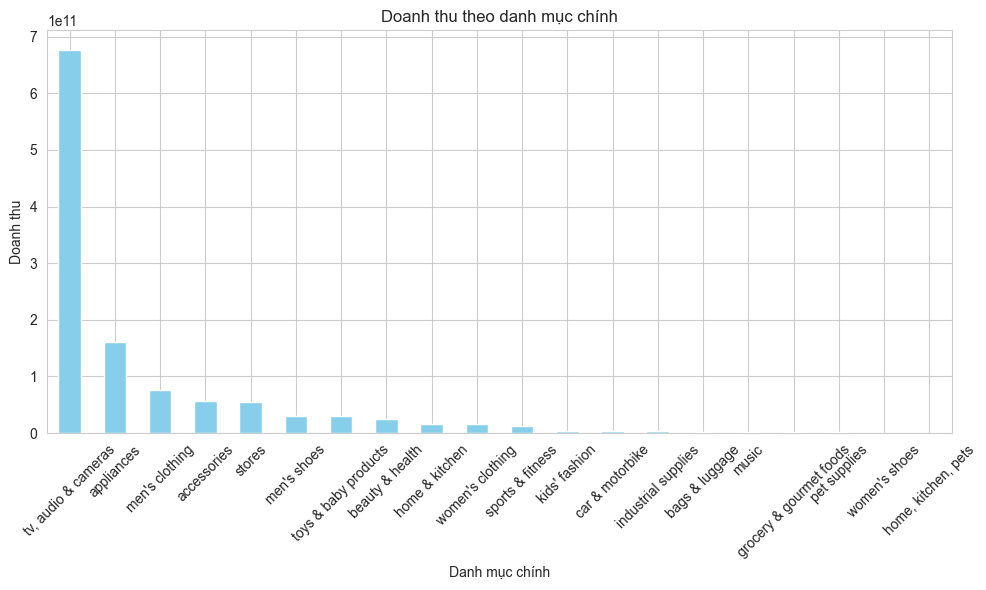

Doanh thu theo danh mục chính:
 main_category
tv, audio & cameras        677208510137
appliances                 161580598665
men's clothing              76086613511
accessories                 57104043562
stores                      55055191983
men's shoes                 30528088349
toys & baby products        30149751005
beauty & health             24879066964
home & kitchen              16358906349
women's clothing            16252010514
sports & fitness            12703338354
kids' fashion                3821758393
car & motorbike              3776939519
industrial supplies          2949141501
bags & luggage               2351847864
music                        1794079774
grocery & gourmet foods      1554455899
pet supplies                 1193624263
women's shoes                 932356479
home, kitchen, pets              122807
Name: revenue, dtype: int64

Xu hướng tăng trưởng:
 main_category  date   
accessories    2024-01    0.000000
               2024-02   -0.093806
         

In [7]:
# Phân tích doanh thu theo main_category
def analyze_category_revenue(df):
    # Tính doanh thu theo main_category
    revenue_by_category = df.groupby('main_category')['revenue'].sum().sort_values(ascending=False)
    
    # Tính xu hướng tăng trưởng (so sánh theo tháng)
    df['date'] = pd.to_datetime(df['date'])
    monthly_trend = df.groupby(['main_category', df['date'].dt.to_period('M')])['revenue'].sum()
    growth_trend = monthly_trend.groupby('main_category').pct_change().fillna(0)
    
    # Sản phẩm bán chạy (dựa trên quantity_sold)
    top_products = df.groupby(['main_category', 'name'])['quantity_sold'].sum().reset_index()
    top_products = top_products.sort_values(['main_category', 'quantity_sold'], ascending=[True, False])
    
    return revenue_by_category, growth_trend, top_products

# Chạy phân tích
revenue, trend, top_products = analyze_category_revenue(df)

# Trực quan hóa doanh thu theo danh mục
plt.figure(figsize=(10, 6))
revenue.plot(kind='bar', color='skyblue')
plt.title('Doanh thu theo danh mục chính')
plt.xlabel('Danh mục chính')
plt.ylabel('Doanh thu')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("Doanh thu theo danh mục chính:\n", revenue)
print("\nXu hướng tăng trưởng:\n", trend)
print("\nSản phẩm bán chạy:\n", top_products.groupby('main_category').head(1))

Random Forest MSE: 5554.125818912205
XGBoost MSE: 7510133.45540378


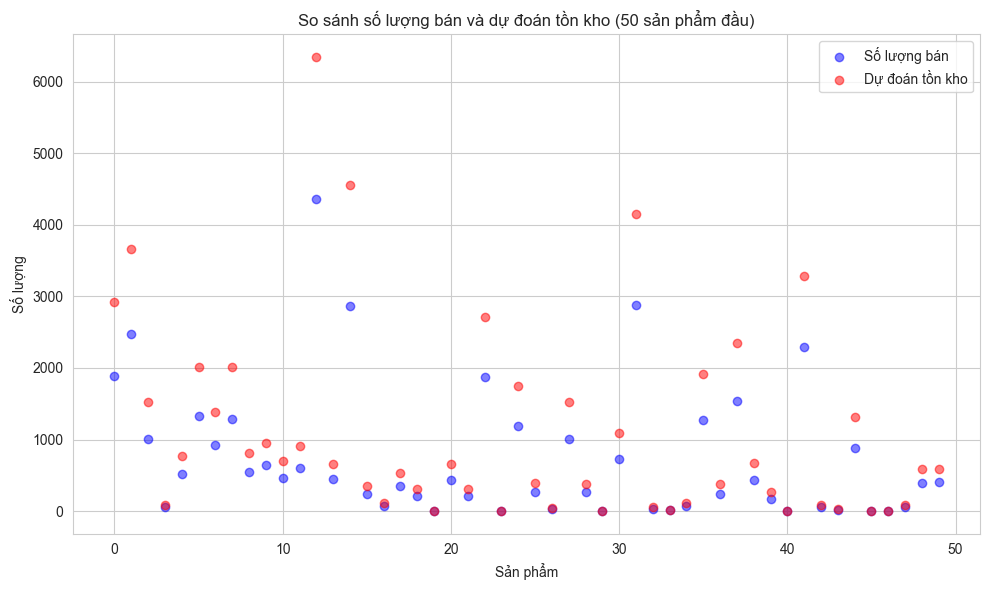

Dự đoán nhu cầu hàng tồn kho (5 dòng đầu):
                                                 name  quantity_sold  \
0  Lloyd 1.5 Ton 3 Star Inverter Split Ac (5 In 1...           1894   
1  LG 1.5 Ton 5 Star AI DUAL Inverter Split AC (C...           2476   
2  LG 1 Ton 4 Star Ai Dual Inverter Split Ac (Cop...           1013   
3  LG 1.5 Ton 3 Star AI DUAL Inverter Split AC (C...             55   
4  Carrier 1.5 Ton 3 Star Inverter Split AC (Copp...            516   

   predicted_inventory  
0          2919.840576  
1          3663.358154  
2          1523.058105  
3            82.227036  
4           769.431580  


In [8]:
# Chuẩn bị dữ liệu
def prepare_inventory_data(df):
    features = ['ratings', 'no_of_ratings', 'discount_price', 'actual_price']
    X = df[features]
    X['month'] = pd.to_datetime(df['date']).dt.month
    # Thêm cột giả định số lượng tồn kho (dựa trên quantity_sold)
    y = (df['quantity_sold'] * 1.5).astype(int)  # Giả định tồn kho cần gấp 1.5 lần số lượng bán
    return X, y

# Chuẩn bị dữ liệu và chia train/test
X, y = prepare_inventory_data(df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Huấn luyện mô hình Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
print("Random Forest MSE:", mean_squared_error(y_test, rf_pred))

# Huấn luyện mô hình XGBoost
xgb_model = XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
print("XGBoost MSE:", mean_squared_error(y_test, xgb_pred))

# Dự đoán số lượng hàng cần nhập kho
inventory_forecast = xgb_model.predict(X)
df['predicted_inventory'] = inventory_forecast

# Trực quan hóa dự đoán
plt.figure(figsize=(10, 6))
plt.scatter(df.index[:50], df['quantity_sold'][:50], label='Số lượng bán', color='blue', alpha=0.5)
plt.scatter(df.index[:50], df['predicted_inventory'][:50], label='Dự đoán tồn kho', color='red', alpha=0.5)
plt.title('So sánh số lượng bán và dự đoán tồn kho (50 sản phẩm đầu)')
plt.xlabel('Sản phẩm')
plt.ylabel('Số lượng')
plt.legend()
plt.tight_layout()
plt.show()

print("Dự đoán nhu cầu hàng tồn kho (5 dòng đầu):\n", df[['name', 'quantity_sold', 'predicted_inventory']].head())

In [14]:
# Cài đặt tabulate nếu chưa có (chạy trong terminal: pip install tabulate)
from tabulate import tabulate

# Lấy mẫu 10,000 sản phẩm để giảm tải bộ nhớ
df_sampled = df.sample(n=10000, random_state=42)

# Chuẩn bị dữ liệu cho hệ thống gợi ý
def prepare_recommendation_data(df_sampled):
    # Chọn các đặc trưng để tính độ tương đồng
    features = ['ratings', 'no_of_ratings', 'discount_price', 'actual_price']
    feature_matrix = df_sampled[features].fillna(0)
    
    # Chuẩn hóa dữ liệu
    feature_matrix = (feature_matrix - feature_matrix.mean()) / feature_matrix.std()
    
    # Tính độ tương đồng cosine giữa các sản phẩm
    similarity_matrix = cosine_similarity(feature_matrix)
    return similarity_matrix

# Tính ma trận tương đồng trên tập dữ liệu đã lấy mẫu
similarity_matrix = prepare_recommendation_data(df_sampled)

# Hàm gợi ý sản phẩm cho từng danh mục
def recommend_products(category, n=3):
    # Lấy danh sách sản phẩm trong danh mục từ tập dữ liệu đã lấy mẫu
    category_products = df_sampled[df_sampled['main_category'] == category]
    category_indices = category_products.index.tolist()
    
    # Nếu danh mục không có sản phẩm trong tập mẫu, trả về rỗng
    if not category_indices:
        return []
    
    # Ánh xạ lại chỉ số từ tập dữ liệu gốc sang tập dữ liệu đã lấy mẫu
    sampled_indices = [df_sampled.index.get_loc(idx) for idx in category_indices]
    
    # Tính điểm trung bình tương đồng của các sản phẩm trong danh mục với tất cả sản phẩm khác
    avg_similarity_scores = np.mean(similarity_matrix[sampled_indices], axis=0)
    
    # Lấy danh sách sản phẩm không thuộc danh mục này
    other_products = df_sampled[df_sampled['main_category'] != category]
    other_indices = other_products.index.tolist()
    
    # Ánh xạ lại chỉ số
    other_sampled_indices = [df_sampled.index.get_loc(idx) for idx in other_indices]
    
    # Sắp xếp các sản phẩm khác theo độ tương đồng
    similarity_scores = [(idx, avg_similarity_scores[sampled_idx]) 
                         for idx, sampled_idx in zip(other_indices, other_sampled_indices)]
    similarity_scores.sort(key=lambda x: x[1], reverse=True)
    
    # Lấy top n sản phẩm
    top_n = similarity_scores[:n]
    recommended_products = [(df.loc[idx, 'name'], score) for idx, score in top_n]
    return recommended_products

# Lấy danh sách các danh mục chính từ tập dữ liệu đã lấy mẫu
categories = df_sampled['main_category'].unique()

# Tạo danh sách để lưu kết quả gợi ý
recommendation_table = []

# Gợi ý sản phẩm cho từng danh mục
for category in categories[:100000]:  # Chỉ lấy 3 danh mục đầu để demo
    recommendations = recommend_products(category)
    if recommendations:
        for product_name, score in recommendations:
            recommendation_table.append([category, product_name, f"{score:.4f}"])
    else:
        recommendation_table.append([category, "Không có gợi ý", "-"])

# In kết quả dưới dạng bảng đẹp
print("\n=== Kết quả gợi ý sản phẩm ===")
headers = ["Danh mục", "Sản phẩm đề xuất", "Điểm tương đồng"]
print(tabulate(recommendation_table, headers=headers, tablefmt="fancy_grid", stralign="left"))


=== Kết quả gợi ý sản phẩm ===
╒═════════════════════════╤═══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╤═══════════════════╕
│ Danh mục                │ Sản phẩm đề xuất                                                                                                              │   Điểm tương đồng │
╞═════════════════════════╪═══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╪═══════════════════╡
│ tv, audio & cameras     │ ASGARD Analog Men's & Boy's Watch (Multicolored Dial, Blue Colored Strap)                                                     │            0.317  │
├─────────────────────────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼───────────────────┤
│ tv, audio & cameras     │ FIMS - Fashion is my style Women Innerwear Lingerie Set for 